# Trader Profiling & Personality Clustering

## Objective:
To cluster professional and retail traders based on their historical trading behavior using unsupervised machine learning techniques, with the goal of identifying trading personalities such as "aggressive," "conservative," and "erratic." These profiles will support capital allocation decisions, personalized risk management, and tailored mentorship strategies within trading firms.



# ========================================
# STEP 1: SETUP & INSTALL DEPENDENCIES
# ========================================

In [ ]:

!pip install yfinance faker pandas scikit-learn matplotlib seaborn --quiet

import yfinance as yf
from faker import Faker
import pandas as pd
import numpy as np
import random
import time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.0 MB/s eta 0:00:00


# ========================================
# STEP 2: SIMULATE TRADE DATA
# ========================================


In [ ]:
fake = Faker()
instruments = ['RELIANCE.BO', 'SBIN.BO', 'INFY.BO', 'TCS.BO', 'ITC.BO']
user_ids = [f"U{1000 + i}" for i in range(300)]
data = []

price_dict = {}

# Download 30-day price history
for symbol in instruments:
    stock = yf.Ticker(symbol)
    time.sleep(2)  # to avoid hitting API limits
    hist = stock.history(period="30d")
    price_dict[symbol] = hist['Close'].dropna().tolist() if not hist.empty else []

# Simulate trades per user
for user in user_ids:
    for _ in range(random.randint(10, 20)):
        symbol = random.choice(instruments)
        prices = price_dict.get(symbol, [])
        if not prices:
            continue
        price = round(random.choice(prices), 2)
        quantity = random.choice([10, 25, 50, 100])
        action = random.choice(['Buy', 'Sell'])
        timestamp = fake.date_time_between(start_date='-30d', end_date='now')
        pnl = round(random.uniform(-5000, 5000), 2)
        data.append([user, fake.uuid4()[:8], timestamp, symbol, action, quantity, price, pnl])

# Create DataFrame
df = pd.DataFrame(data, columns=['user_id', 'trade_id', 'timestamp', 'instrument', 'action', 'quantity', 'price', 'pnl'])
df.to_csv('trader_logs_api_generated.csv', index=False)
print(" Trade log saved as 'trader_logs_api_generated.csv'")

 Trade log saved as 'trader_logs_api_generated.csv'


# ========================================
# STEP 3: FEATURE ENGINEERING AND SCALING
# ========================================

In [ ]:
# Feature engineering
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['is_win'] = df['pnl'] > 0

# Aggregate features per trader
trader_features = df.groupby('user_id').agg(
    avg_pnl=('pnl', 'mean'),
    pnl_std=('pnl', 'std'),
    max_drawdown=('pnl', lambda x: x[x < 0].sum()),
    win_rate=('is_win', 'mean'),
    trade_count=('trade_id', 'count'),
    avg_quantity=('quantity', 'mean'),
    avg_price=('price', 'mean'),
    total_pnl=('pnl', 'sum')
).reset_index()

trader_features.fillna(0, inplace=True)

# Scaling features for clustering
scaler = StandardScaler()
X = scaler.fit_transform(trader_features.drop('user_id', axis=1))


# ========================================
# STEP 4: COMPARE MULTIPLE CLUSTERING ALGORITHMS & VISUALIZE BEST
# ========================================


Running KMeans clustering...
KMeans: Clusters = 4, Silhouette Score = 0.1761, Inertia = 1330.0507045563352

Running Agglomerative clustering...
Agglomerative: Clusters = 4, Silhouette Score = 0.1351, Inertia = None

Running GaussianMixture clustering...
GaussianMixture: Clusters = 4, Silhouette Score = 0.1534, Inertia = None

Running SpectralClustering clustering...
SpectralClustering: Clusters = 4, Silhouette Score = 0.1552, Inertia = None

Running Birch clustering...
Birch: Clusters = 4, Silhouette Score = 0.1305, Inertia = None


/tmp/ipython-input-4-3929265199.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=sil_scores, palette="viridis")


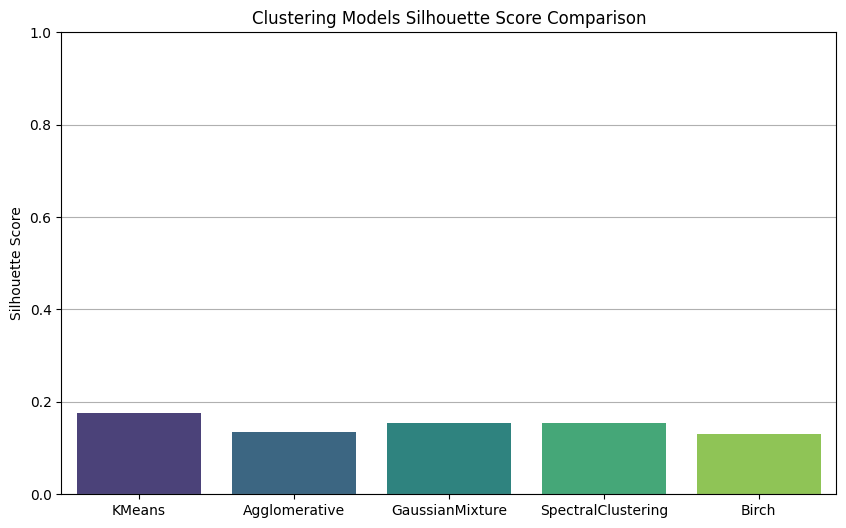


Best model selected: KMeans with Silhouette Score: 0.1761
Saved best KMeans model as 'best_kmeans_model.pkl'


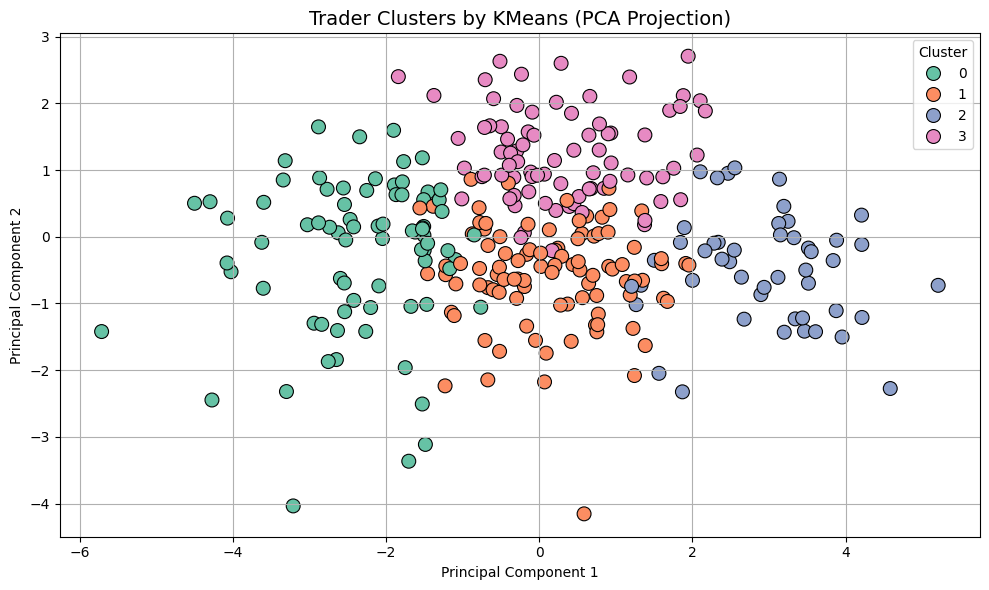

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

best_k = 4  # Set your number of clusters here

clustering_algorithms = {
    "KMeans": KMeans(n_clusters=best_k, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=best_k),
    "GaussianMixture": GaussianMixture(n_components=best_k, random_state=42),
    "SpectralClustering": SpectralClustering(n_clusters=best_k, assign_labels='kmeans', random_state=42),
    "Birch": Birch(n_clusters=best_k)
}

results = []

for name, model in clustering_algorithms.items():
    print(f"\nRunning {name} clustering...")

    if name == "GaussianMixture":
        cluster_labels = model.fit_predict(X)
    else:
        cluster_labels = model.fit_predict(X)

    n_clusters = len(set(cluster_labels))
    if n_clusters <= 1:
        print(f"{name} found {n_clusters} clusters. Skipping silhouette score.")
        sil_score = -1
    else:
        sil_score = silhouette_score(X, cluster_labels)

    inertia = getattr(model, 'inertia_', None)  # Only KMeans has inertia_

    print(f"{name}: Clusters = {n_clusters}, Silhouette Score = {sil_score:.4f}, Inertia = {inertia}")

    results.append({
        "Model": name,
        "Clusters": n_clusters,
        "Silhouette Score": sil_score,
        "Inertia": inertia if inertia is not None else 0,
        "Labels": cluster_labels,
        "ModelInstance": model
    })

# Plot silhouette scores comparison
models = [r["Model"] for r in results]
sil_scores = [r["Silhouette Score"] for r in results]

plt.figure(figsize=(10,6))
sns.barplot(x=models, y=sil_scores, palette="viridis")
plt.title("Clustering Models Silhouette Score Comparison")
plt.ylabel("Silhouette Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Select best model by silhouette score (prefer KMeans if tied or top)
results_sorted = sorted(results, key=lambda x: x["Silhouette Score"], reverse=True)
top_score = results_sorted[0]["Silhouette Score"]
top_models = [r for r in results_sorted if r["Silhouette Score"] == top_score]

if any(r["Model"] == "KMeans" for r in top_models):
    best_model = next(r for r in top_models if r["Model"] == "KMeans")
else:
    best_model = top_models[0]

print(f"\nBest model selected: {best_model['Model']} with Silhouette Score: {best_model['Silhouette Score']:.4f}")

# Assign cluster labels to your DataFrame
trader_features['cluster'] = best_model['Labels']

# Save KMeans model if it is best
if best_model['Model'] == "KMeans":
    joblib.dump(best_model['ModelInstance'], 'best_kmeans_model.pkl')
    print("Saved best KMeans model as 'best_kmeans_model.pkl'")

# PCA plot of best model clusters
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)
trader_features['PC1'] = pca_components[:, 0]
trader_features['PC2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=trader_features, x='PC1', y='PC2',
    hue='cluster', palette='Set2', s=100, edgecolor='black'
)
plt.title(f'Trader Clusters by {best_model["Model"]} (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()



# ========================================
# STEP 5: Visualizing Clusters and Feature Distributions
# ========================================

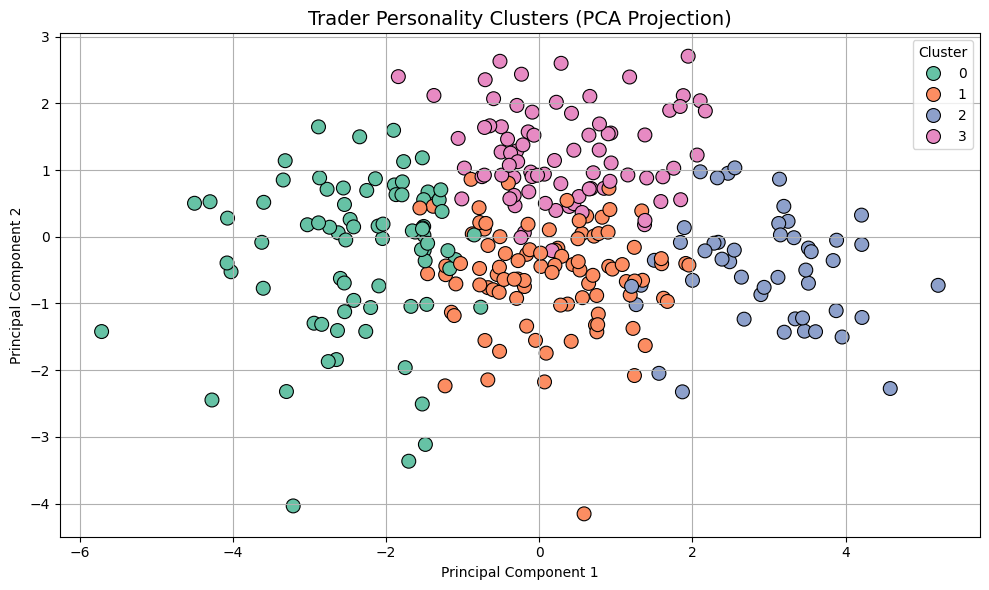

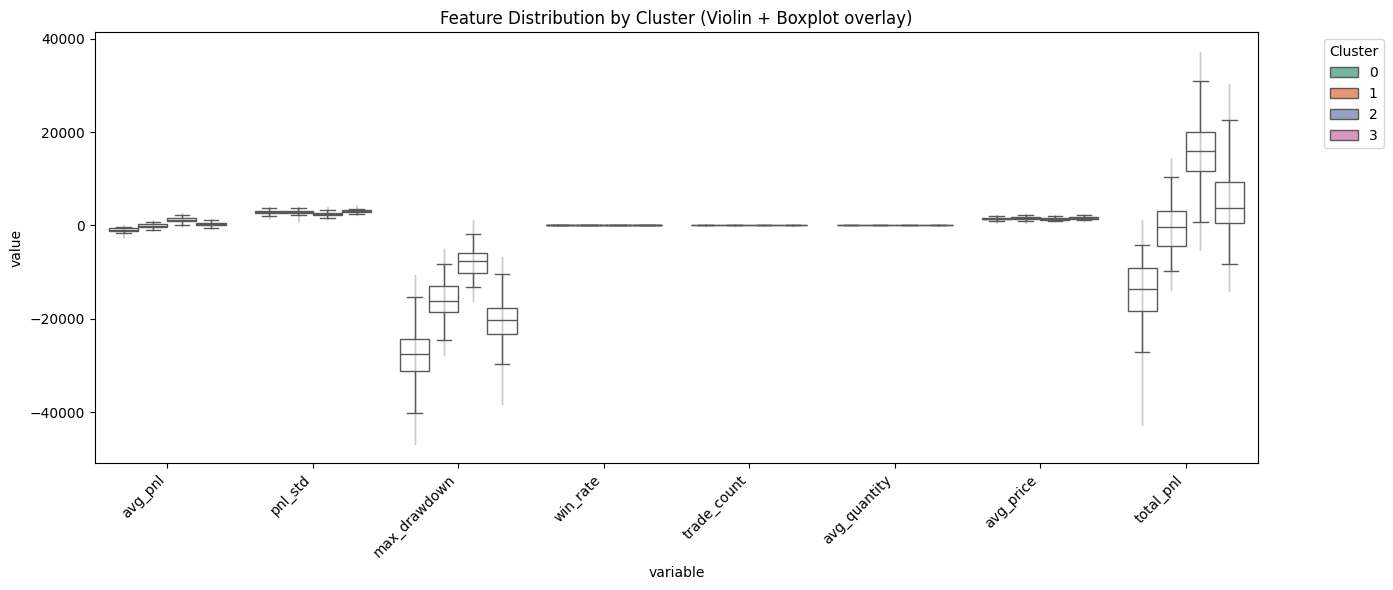

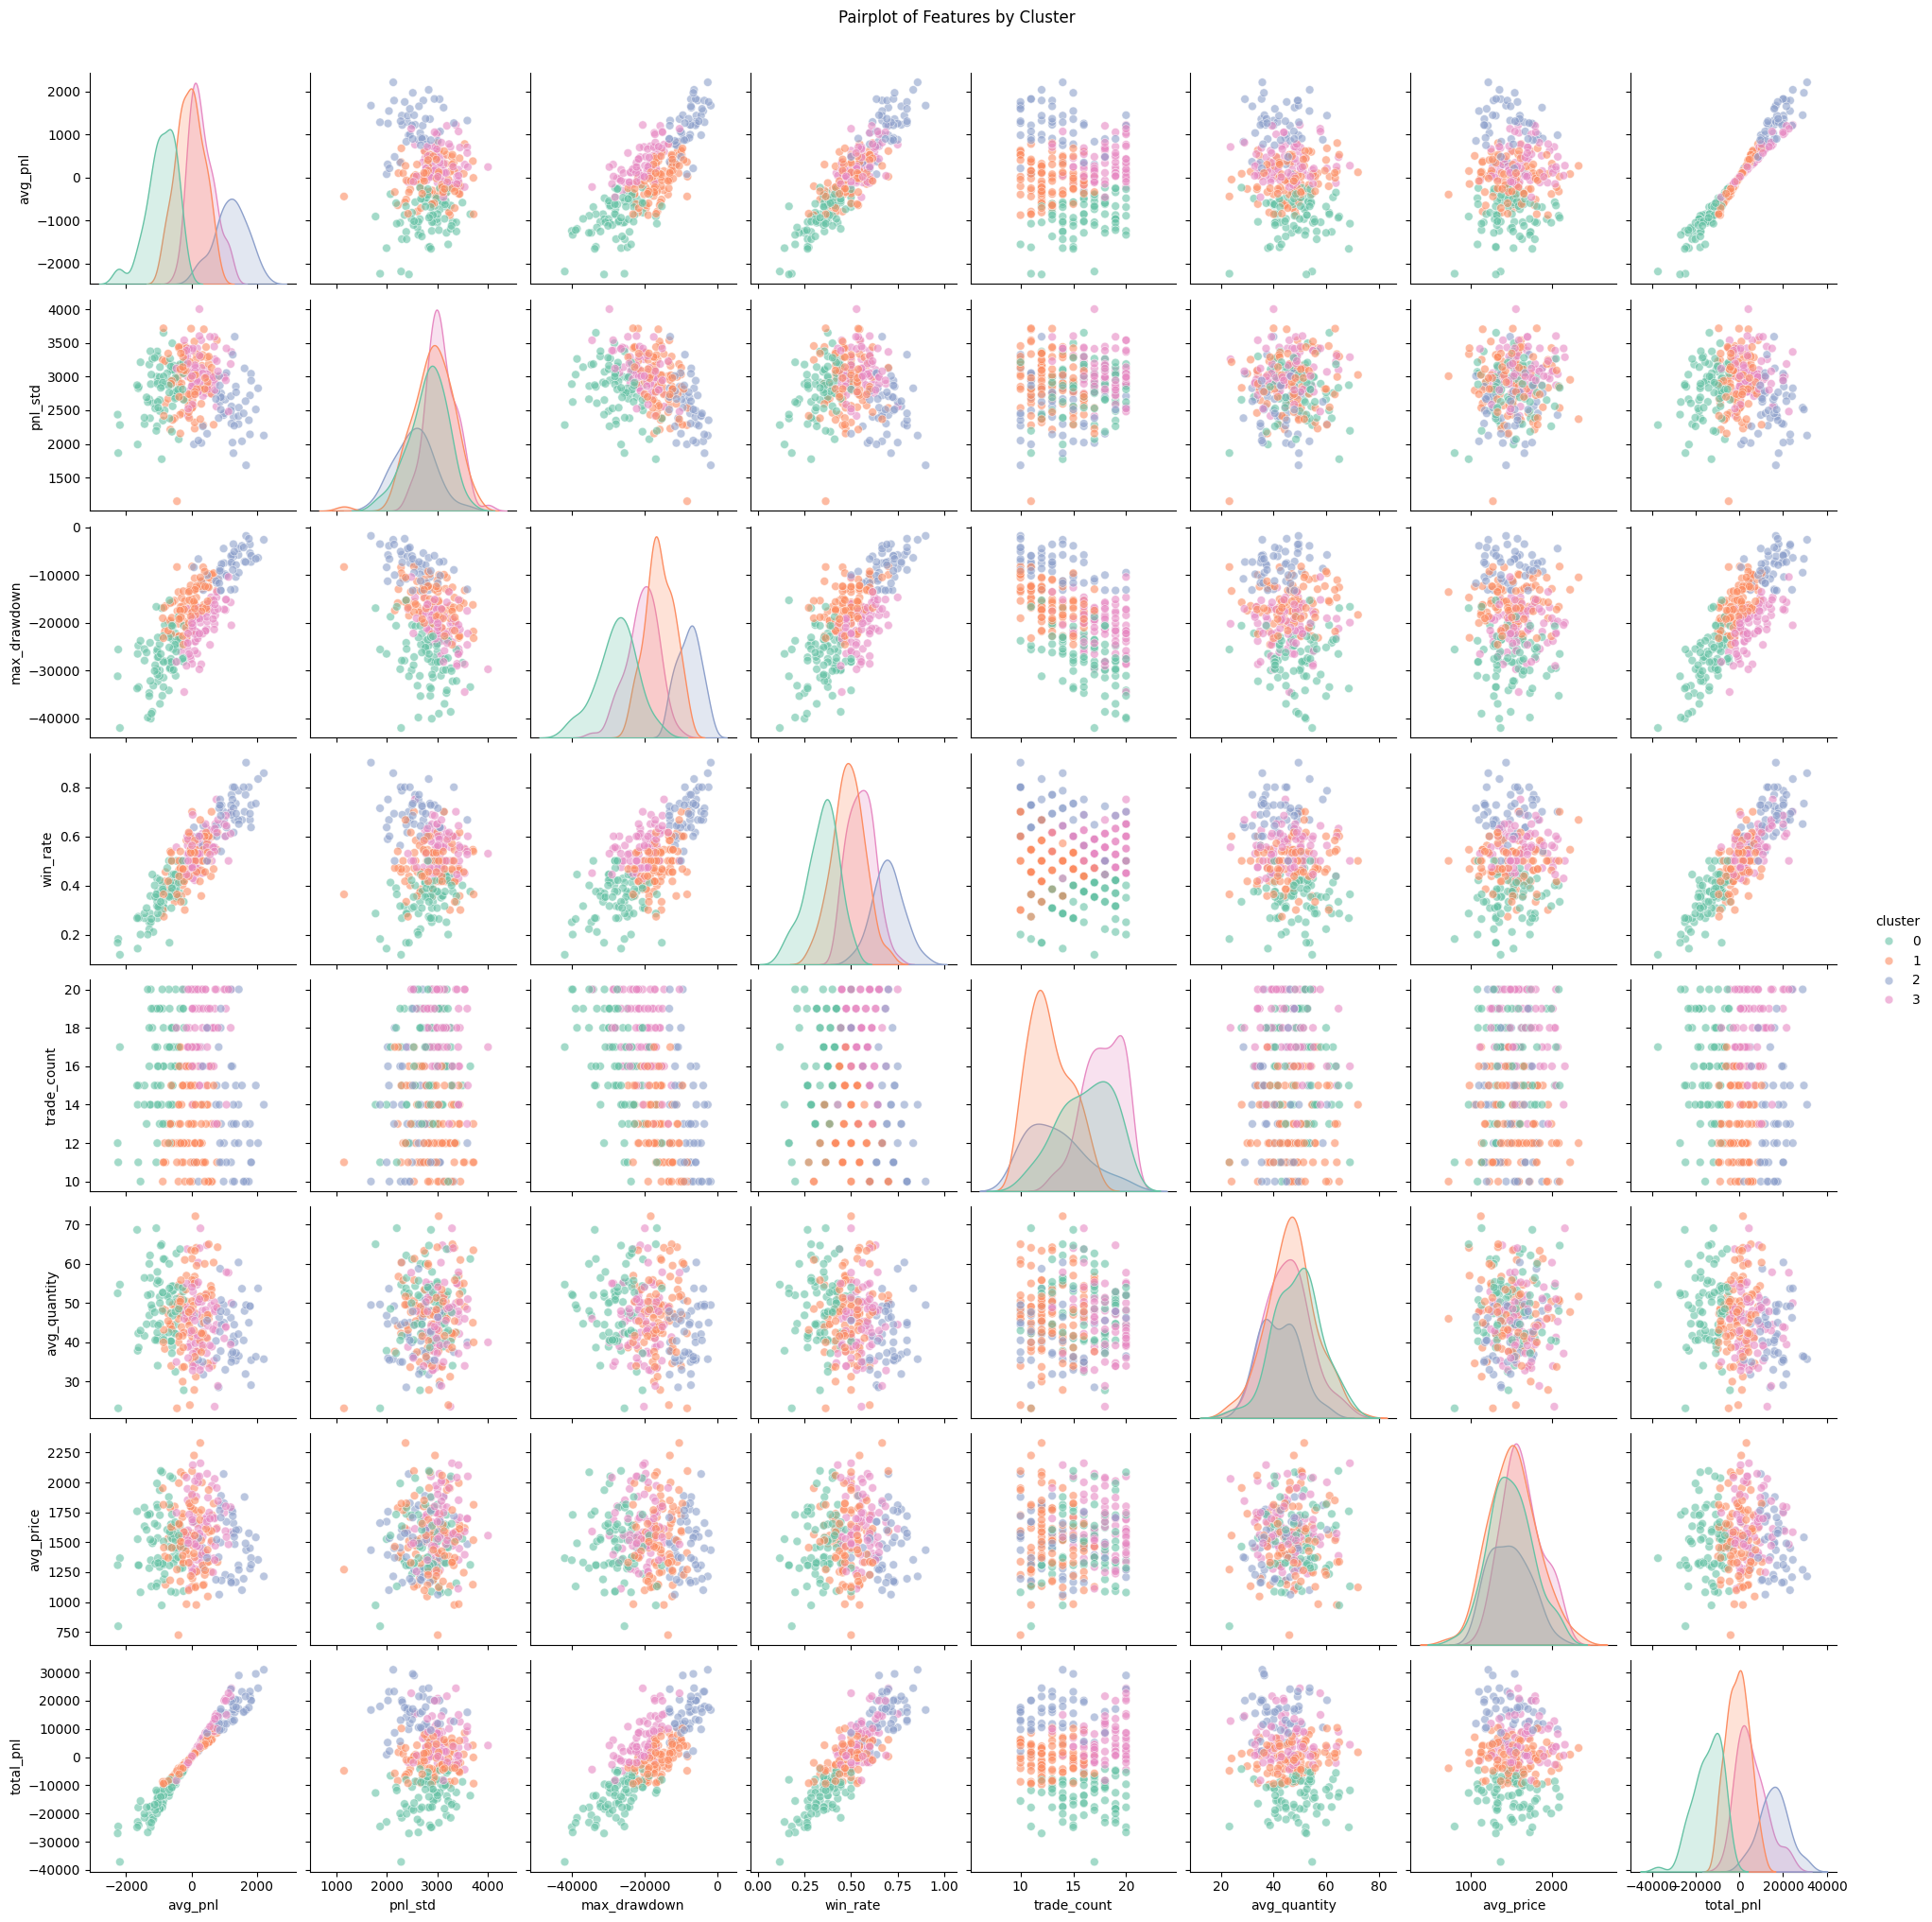

/tmp/ipython-input-6-954033273.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')


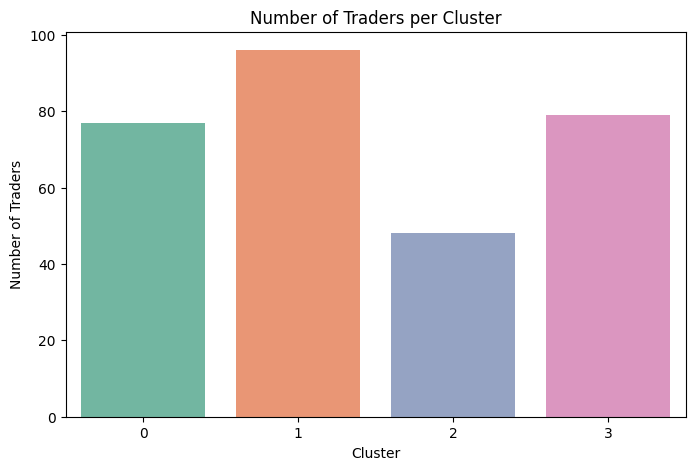

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define features to plot
features_to_plot = ['avg_pnl', 'pnl_std', 'max_drawdown', 'win_rate', 'trade_count', 'avg_quantity', 'avg_price', 'total_pnl']

# Melt the DataFrame for plotting feature distributions by cluster
melted = trader_features.melt(id_vars=['user_id', 'cluster'], value_vars=features_to_plot)

# 1. PCA Scatterplot (you already have this, but here for completeness)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=trader_features, x='PC1', y='PC2', hue='cluster', palette='Set2', s=100, edgecolor='black')
plt.title('Trader Personality Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 2. Boxplot + Violin plot combined for feature distributions by cluster
fig, ax = plt.subplots(figsize=(14, 6))
sns.violinplot(data=melted, x='variable', y='value', hue='cluster', palette='Set2',
               inner="quartile", linewidth=1, alpha=0.3, ax=ax)
sns.boxplot(data=melted, x='variable', y='value', hue='cluster', palette='Set2',
            fliersize=0, linewidth=1, boxprops={'facecolor':'none'}, ax=ax)

# Remove duplicate legends and keep one
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Feature Distribution by Cluster (Violin + Boxplot overlay)")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

# 3. Pairplot of selected features colored by cluster
sns.pairplot(trader_features, vars=features_to_plot, hue='cluster', palette='Set2', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 40})
plt.suptitle('Pairplot of Features by Cluster', y=1.02)
plt.show()

# 4. Cluster Size Bar Plot
cluster_counts = trader_features['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')
plt.xlabel('Cluster')
plt.ylabel('Number of Traders')
plt.title('Number of Traders per Cluster')
plt.show()

# ========================================
# STEP 6: CLUSTER SUMMARY REPORT
# ========================================

Cluster Feature Summary:
             avg_pnl                               pnl_std               \
                mean       median         std         mean       median   
cluster                                                                   
0        -920.220730  -877.859231  451.707527  2804.582518  2858.442956   
1         -51.300680   -24.216848  411.197621  2904.618301  2916.922153   
2        1194.017673  1239.299519  496.697758  2538.542766  2524.597869   
3         307.211291   239.961579  379.912347  3067.539417  3036.300598   

                     max_drawdown                          win_rate  ...  \
                std          mean     median          std      mean  ...   
cluster                                                              ...   
0        378.093493 -27766.561039 -27545.530  5553.599625  0.343204  ...   
1        407.704891 -15939.038229 -16182.575  3859.458670  0.484270  ...   
2        386.987703  -7903.095000  -7552.985  3144.493434  0.696402  

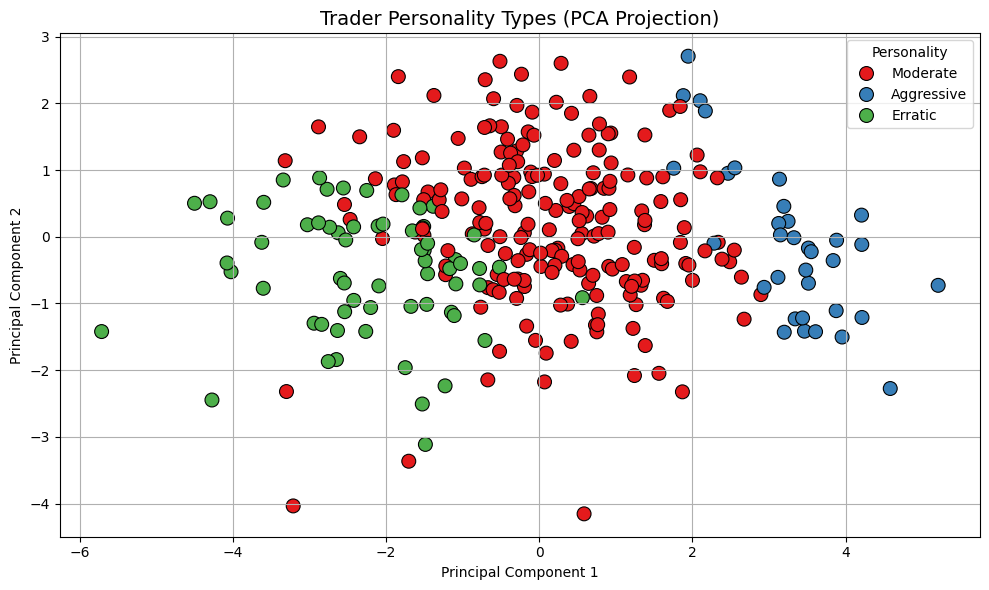

In [ ]:
# Step 6: Cluster Summary, Personality Assignment, and Visualization

# 1. Summarize feature stats by cluster
cluster_summary = trader_features.groupby('cluster')[features_to_plot].agg(['mean', 'median', 'std'])
print("Cluster Feature Summary:")
print(cluster_summary)

# 2. Define function to assign personality based on key features
def assign_personality(row):
    if row['win_rate'] > 0.6 and row['avg_pnl'] > 1000:
        return "Aggressive"
    elif row['win_rate'] < 0.4 and row['pnl_std'] > 2000:
        return "Erratic"
    elif row['win_rate'] > 0.5 and row['pnl_std'] < 1000:
        return "Conservative"
    else:
        return "Moderate"

# 3. Apply the personality assignment function
trader_features['personality'] = trader_features.apply(assign_personality, axis=1)

# 4. Visualize personality clusters with PCA projection
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=trader_features, x='PC1', y='PC2',
    hue='personality', palette='Set1', s=100, edgecolor='black'
)
plt.title('Trader Personality Types (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Personality')
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 7: Detailed Cluster Analysis and Reporting

Cluster Summary Statistics:
         avg_pnl          pnl_std         win_rate       trade_count        \
            mean     std     mean     std     mean   std        mean   std   
cluster                                                                      
0        -920.22  451.71  2804.58  378.09     0.34  0.09       16.17  2.56   
1         -51.30  411.20  2904.62  407.70     0.48  0.09       12.78  1.94   
2        1194.02  496.70  2538.54  386.99     0.70  0.08       13.40  2.80   
3         307.21  379.91  3067.54  291.20     0.55  0.07       17.78  1.84   

        total_pnl           
             mean      std  
cluster                     
0       -14398.38  6476.35  
1         -682.69  5068.59  
2        15705.02  6686.06  
3         5529.35  6963.75  


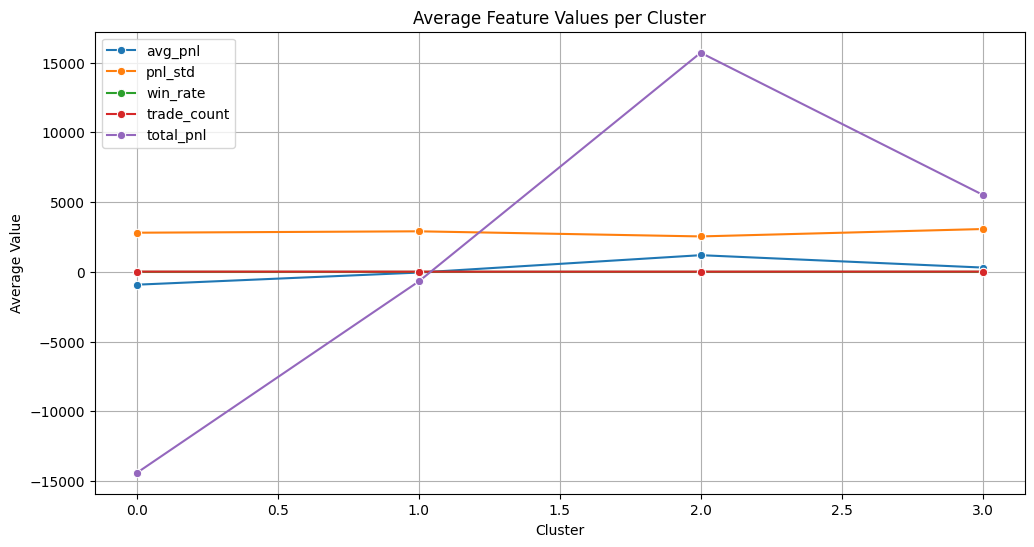

Saved cluster summary statistics to 'cluster_summary_statistics.csv'


In [ ]:

# Summary statistics per cluster
cluster_summary = trader_features.groupby('cluster').agg({
    'avg_pnl': ['mean', 'std'],
    'pnl_std': ['mean', 'std'],
    'win_rate': ['mean', 'std'],
    'trade_count': ['mean', 'std'],
    'total_pnl': ['mean', 'std']
}).round(2)

print("Cluster Summary Statistics:")
print(cluster_summary)

# Visualize average feature values per cluster
features_to_plot = ['avg_pnl', 'pnl_std', 'win_rate', 'trade_count', 'total_pnl']

cluster_means = trader_features.groupby('cluster')[features_to_plot].mean().reset_index()

plt.figure(figsize=(12, 6))
for feature in features_to_plot:
    sns.lineplot(data=cluster_means, x='cluster', y=feature, marker='o', label=feature)

plt.title('Average Feature Values per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, save summary to CSV
cluster_summary.to_csv('cluster_summary_statistics.csv')
print("Saved cluster summary statistics to 'cluster_summary_statistics.csv'")


# Scaler object —  to preprocess new data exactly like our training data.

In [ ]:
import joblib

# Save scaler if not already saved
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [ ]:
# Final trader personality data
trader_features.to_pickle("final_trader_features.pkl")
print("✅ Saved: final_trader_features.pkl")  # to retain the datatypes

✅ Saved: final_trader_features.pkl


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
'''import os
import joblib

# Define the folder path
folder_path = "/content/drive/MyDrive/Saurabh_Internship_Project/"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# ✅ Save the final dataset
trader_features.to_csv(folder_path + "final_trader_features.csv", index=False)

# ✅ Save the best clustering model
joblib.dump(best_model['ModelInstance'], folder_path + "best_kmeans_model.pkl")

# ✅ Save the scaler
joblib.dump(scaler, folder_path + "scaler.pkl")

print("✅ All files saved to: " + folder_path)
'''


'import os\nimport joblib\n\n# Define the folder path\nfolder_path = "/content/drive/MyDrive/Saurabh_Internship_Project/"\n\n# Create the folder if it doesn\'t exist\nos.makedirs(folder_path, exist_ok=True)\n\n# ✅ Save the final dataset\ntrader_features.to_csv(folder_path + "final_trader_features.csv", index=False)\n\n# ✅ Save the best clustering model\njoblib.dump(best_model[\'ModelInstance\'], folder_path + "best_kmeans_model.pkl")\n\n# ✅ Save the scaler\njoblib.dump(scaler, folder_path + "scaler.pkl")\n\nprint("✅ All files saved to: " + folder_path)\n'